# HW 5
IS 527 Homework 5
Hou-Chun Liu
4 Apr. 2024

In [1]:
import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.lines import Line2D

In [2]:
def draw(G, z):
    # pos = nx.spring_layout(G=G, seed=42)

    node_color = []
    group_labels = ['Class 0', 'Class 1', 'Class 2']
    colors = ['blue', 'red', 'yellow']
    for i in range(len(G.nodes)):
        node_color.append(colors[z[i]])

    pos = nx.spring_layout(G, seed=42)  # You can use other layout functions as well
    nx.draw_networkx_nodes(G, pos, node_color=node_color)
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)

    # Create proxy artists for the legend
    proxy_artists = [Line2D([0], [0], marker='o', color=color, label=label, markerfacecolor=color, markersize=8)
                     for color, label in zip(colors, group_labels)]

    # Add legend
    plt.legend(handles=proxy_artists, loc='upper right')
    plt.show()

### Graph G in Problem 3

=== Graph G in Problem 3 ===


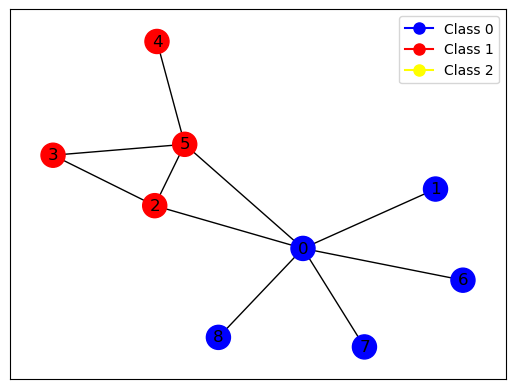

In [3]:
def init_G():
    G = nx.Graph()
    for i in range(0, 9):
        G.add_node(i)
    edges = [(0, 1), (0, 2), (0, 5), (0, 6), (0, 7), (0, 8), (2, 3), (2, 5), (3, 5), (4, 5)]
    for edge in edges:
        G.add_edge(edge[0], edge[1])
    return G
G = init_G()
z_example = [0, 0, 1, 1, 1, 1, 0, 0, 0]
print("=== Graph G in Problem 3 ===")
draw(G, z_example)

### (a) (15 pts) Write a function makeAMove() that implements the core logic of the algorithm:
• Input: a graph G, a current partition zt, a number of groups c, and a binary “is-Frozen” vector f (if fi = 1, then i is “frozen”)
• This function should loop over the n − t unfrozen nodes (those with fi = 0) and c − 1 possible single-node moves for each of those nodes and compute a log-likelihood of each combination.
• Over that loop, it should track the single best log-likelihood L∗ and the corresponding ”best move,” i.e., a pair (i, zi) where zi is i’s new group label r.
• Output: the final L∗ and the pair (i, zi ) the represent the change to zt that would yield L∗.

In [4]:
def makeAMove(g, z, c, is_frozen):
    '''
    Input: a graph G, a current partition zt, a number of groups c, and a binary “is-Frozen” vector f (if fi = 1, then i is “frozen”)
• This function should loop over the n − t unfrozen nodes (those with fi = 0) and c − 1 possible single-node moves for each of those nodes and compute a log-likelihood of each combination.
• Over that loop, it should track the single best log-likelihood L∗ and the corresponding ”best move,” i.e., a pair (i, zi) where zi is i’s new group label r.
• Return:: the final L∗ and the pair (i, zi ) the represent the change to zt that would yield L∗.
    '''
    n = len(g.nodes)
    max_likelihood = -np.inf
    best_move = [None, None]
    for i in range(n):
        if is_frozen[i] == 1:
            continue
        old = z[i]
        for zi in range(c):
            z[i] = zi
            L = log_likelihood(g, z, c)
            if L >= max_likelihood:
                max_likelihood = L
                best_move[0] = i
                best_move[1] = zi
            z[i] = old
    z[best_move[0]] = best_move[1]
    return max_likelihood, best_move


def log_likelihood(g, z, c):
    kappa = {}
    omega = {}
    L = 0
    for i in range(c):
        kappa[i] = 0
        omega[i] = {}
        for j in range(c):
            omega[i][j] = 0.001
    for edge in g.edges():
        lc = z[edge[0]]
        rc = z[edge[1]]
        omega[lc][rc] += 1
        if lc != rc:
            omega[rc][lc] += 1
    for k in kappa.keys():
        for s in omega[k].keys():
            kappa[k] += omega[k][s]
    # print(omega)
    for r in range(c):
        for s in range(r, c):
            if omega[r][s] == 0:
                print(r, s)
                continue
            L += omega[r][s] * np.log(omega[r][s] / (kappa[r] * kappa[s]))

    return L


### Apply makeAMove() to the simple graph G in Problem 3, with c = 3, a random input partition zt, and fi = 0 for all i except f2 = 1.

In [5]:
c = 3
is_frozen = [0 for i in range(len(G.nodes))]
is_frozen[1] = 1
z0 = [random.randint(0, 2) for i in range(len(G.nodes))]
z = z0.copy()
L, (i, zi) = makeAMove(G, z, c, is_frozen)

### Provide a visualization of (i) the input graph G with its node labels zt and its log-likelihood under the DC-SBM

=== Initial State ===
Random z: [2, 2, 1, 1, 1, 0, 2, 1, 1]
Initial Log-Likelihood = -27.5


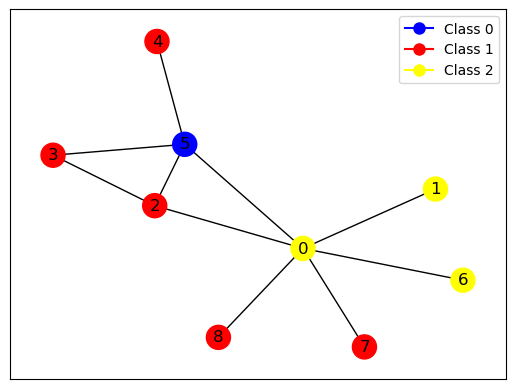

In [6]:
# Random Initialize
print('=== Initial State ===')
print("Random z:", z0)
print(f"Initial Log-Likelihood = {round(log_likelihood(G, z0, c),2)}")
draw(G, z0)

### (ii) the graph G with node labels after applying the best move found and its DC-SBM log-likelihood.

=== After one move ===
z: [2, 2, 1, 1, 1, 0, 2, 1, 2]
Log-Likelihood = -26.27


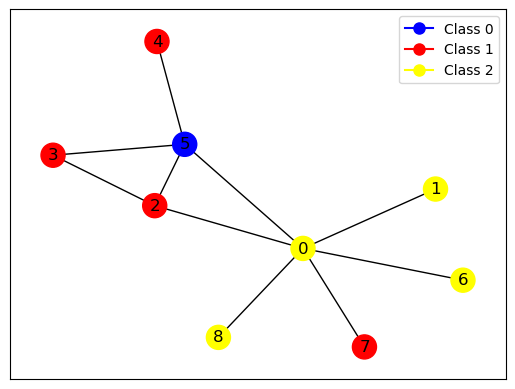

In [7]:
print("=== After one move ===")
print("z:", z)
print(f"Log-Likelihood = {round(log_likelihood(G, z, c),2)}")
draw(G, z)

### (b) (15 pts) Write a function runOnePhase() that runs a single phase from start to finish, starting with an input partition z0 and and evaluates the algorithm’s convergence criteria:
• Input: a graph G, an initial partition z0, and the number of groups c.
• Output: the best partition of the phase z∗ and its correspond- ing DC-SBM log-likelihood L∗, a binary value h that indicates whether the halting criteria was met or not, and a list l that stores the n + 1 log-likelihood values for the n + 1 partitions con- sidered in the phase (this part is purely so that we can make a nice visualization of the algorithm’s progression).
• Remember that when the phase begins, f is all zeros (all nodes unfrozen), and we call makeAMove() to decide which node to “freeze” in a given step of the phase.


In [8]:
def runOnePhase(g, z, c):
    Ls = [log_likelihood(g, z, c)]
    is_frozen = [0 for _ in range(len(g.nodes))]
    z0 = z.copy()
    h = False

    for t in range(len(z)):
        L, (i, zi) = makeAMove(g, z, c, is_frozen)
        is_frozen[i] = 1
        z[i] = zi
        Ls.append(L)
        # print(z)
    if Ls[-1] <= Ls[0]:
        h = True
        z = z0.copy()
        L = Ls[0]

    Ls.append(L)
    return z, h, L, Ls

### Apply runOnePhase() to the simple graph G in Problem 3, with c = 3, a random input partition z0.

In [9]:
G = init_G()
z0 = [random.randint(0, 2) for i in range(len(G.nodes))]
z = z0.copy()
z, h, L, Ls = runOnePhase(G, z, c)

### Provide a visualization of (i) the input graph G with its node labels z0 and its log-likelihood under the DC-SBM

=== Initial State ===
Random z: [0, 1, 2, 1, 0, 1, 2, 2, 1]
Initial Log-Likelihood = -27.05


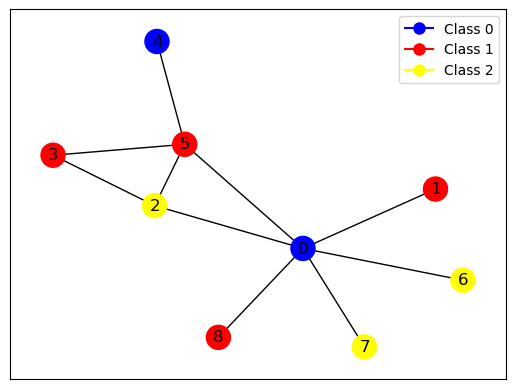

In [10]:
print('=== Initial State ===')
print("Random z:", z0)
print(f"Initial Log-Likelihood = {round(log_likelihood(G, z0, c), 2)}")
draw(G, z0)

### (ii) the graph G with node labels z∗ at the end of the phase and its DC-SBM log-likelihood L∗

=== After one phase ===
z: [2, 2, 1, 0, 0, 1, 2, 2, 2]
Log-Likelihood = -23.57


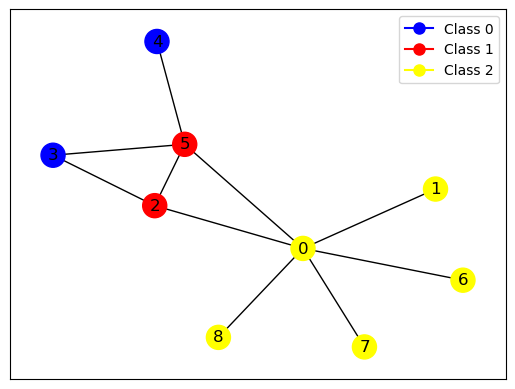

In [11]:
print("=== After one phase ===")
print("z:", z)
print(f"Log-Likelihood = {round(log_likelihood(G, z, c), 2)}")
draw(G, z)

### (iii) a plot of lt showing how the log-likelihood evolved over the course of the phase.

Text(0.5, 1.0, 'Log-Likelihood through One Phase')

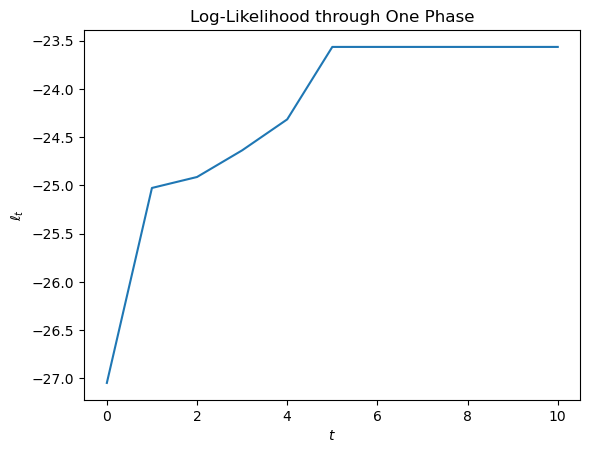

In [12]:
plt.plot(Ls)
plt.xlabel('$t$')
plt.ylabel('$\ell_t$')
plt.title('Log-Likelihood through One Phase')

### (c) (15 pts) Write a function fitDCSBM() that runs the full locally greedy heuristic.
• Input: a graph G, a number of groups c, and the maximum of phases allowed T.
• Output: the best partition z∗ and its log-likelihood L∗ found across all phases, an integer pc that counts the number of phases used, and a list l that stores the log-likelihood values for the pc(n + 1) steps taken across all phases (also purely to make a nice visualization of the algorithm’s progression).

In [13]:
def fitDCSBM(g, c, T):
    z = [random.randint(0, c - 1) for i in range(len(g.nodes))]
    Lss = []
    pc = 0
    for pc in range(T):
        z, h, L, Ls = runOnePhase(g, z, c)
        Lss += Ls
        # print(result)
        if h:
            break
    return z, Lss, pc

### Apply fitDCSBM() to the simple graph G in Problem 3 with c = 3 and T = 30 phases at most.

In [14]:
T = 30
c = 3
G = init_G()
z_star, Lss, pc = fitDCSBM(G, c, T)

### (i) the graph G with final node labels z∗ and its DC-SBM log- likelihood L∗

=== After fitting ===
z: [0, 1, 2, 2, 2, 2, 1, 1, 1]
Log-Likelihood = -21.78


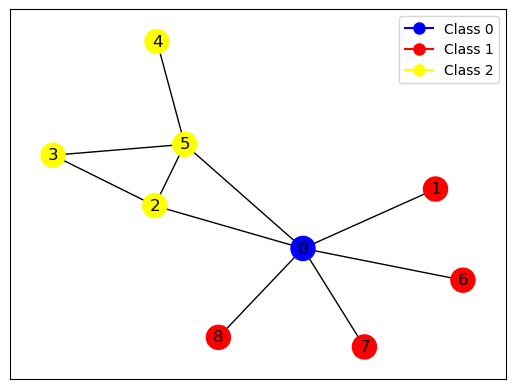

In [15]:
print("=== After fitting ===")
print("z:", z_star)
print(f"Log-Likelihood = {round(log_likelihood(G, z_star, c),2 )}")
draw(G, z_star)


### (ii) a plot of lt showing how the log-likelihood evolved over the course of all the phases

[0, 1, 2, 2, 2, 2, 1, 1, 1]


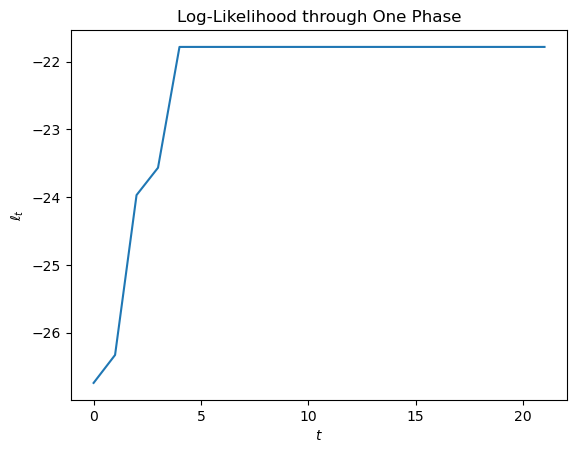

In [16]:
plt.plot(Lss)
plt.xlabel('$t$')
plt.ylabel('$\ell_t$')
plt.title('Log-Likelihood through One Phase')
print(z_star)

### (iii) report the κ vector and ω matrix for the final partition.

In [17]:
def matrix(g, z, c):
    kappa = {}
    omega = {}
    for i in range(c):
        kappa[i] = 0
        omega[i] = {}
        for j in range(c):
            omega[i][j] = 0
    for edge in g.edges():
        lc = z[edge[0]]
        rc = z[edge[1]]
        omega[lc][rc] += 1
        if lc != rc:
            omega[rc][lc] += 1
    for k in kappa.keys():
        for s in omega[k].keys():
            kappa[k] += omega[k][s]
    result = np.ndarray((c, c))
    for r in range(c):
        for s in range(c):
            result[r][s] = omega[r][s]

    return result, kappa


result = matrix(G, z_star, c)
print('=== omega ===')
print(result[0])
print('=== kappa ===')
print(result[1])

=== omega ===
[[0. 4. 2.]
 [4. 0. 0.]
 [2. 0. 4.]]
=== kappa ===
{0: 6, 1: 4, 2: 6}


### Comment briefly on what you see in both the quality of the final partition and in the behavior of lt.
Hint: How good a partition can you get? You may get a log-likelihood of −48.14 or so.

The partition looks very good. From the line plot, you can see the likelihood increased over time. The highest log-likelihood I got is around -21.78. However, due to the randomness of the initial z, most of the time it would converge at an optimal of likelihood around -23. 

### (d) (15 pts) Write a function that repeatedly applies fitDCSBM() to the Zachary karate club network, and tracks the best output over repe- titions. (Although the algorithm itself is deterministic, it begins at a random initial partition, and so re-running the algorithm many times allows us to sample different local optima, looking for a good one.) Tinker with the number of repetitions needed to obtain the optimal

In [18]:
def draw_c(G, z, c):
    # pos = nx.spring_layout(G=G, seed=42)

    node_color = []
    group_labels = [f'Class {i}' for i in range(c)]
    colors = ['blue', 'red', 'pink', 'orange', 'green', 'yellow', 'cyan', 'magenta', 'white', 'purple']
    colors = colors[0:c]
    # print(colors)
    for i in range(len(G.nodes)):
        node_color.append(colors[z[i]])

    pos = nx.spring_layout(G, seed=42)  # You can use other layout functions as well
    nx.draw_networkx_nodes(G, pos, node_color=node_color)
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)

    # Create proxy artists for the legend
    proxy_artists = [Line2D([0], [0], marker='o', color=color, label=label, markerfacecolor=color, markersize=8)
                     for color, label in zip(colors, group_labels)]

    # Add legend
    plt.legend(handles=proxy_artists, loc='upper right')
    plt.show()

=== Initial ===
z: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Log-Likelihood = -330.51


Text(0.5, 1.0, 'Karate Club Graph')

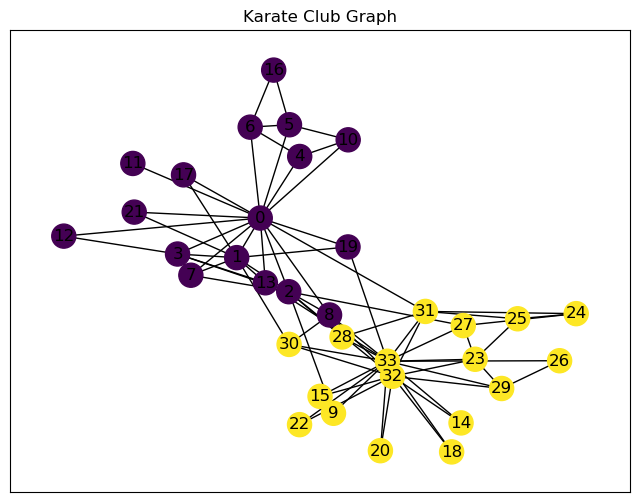

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
# Load Karate Club graph
karate_club_graph = nx.karate_club_graph()

# Community assignment on the Karate Club graph
node_community_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
node_community_map = {}
for i in range(len(node_community_list)):
    node_community_map[i] = node_community_list[i]

# Assigning colors to nodes based on their community
colors = [node_community_map[node] for node in karate_club_graph.nodes()]
print("=== Initial ===")
print("z:", node_community_list)
print(f"Log-Likelihood = {round(log_likelihood(karate_club_graph, node_community_list, 2),2 )}")
# Plotting the graph with nodes colored by community
pos2 = nx.spring_layout(karate_club_graph,seed = 42)
plt.figure(figsize=(8, 6))
nx.draw_networkx(karate_club_graph, pos=pos2, node_color=colors, with_labels=True)
plt.title("Karate Club Graph")

In [20]:
import _pickle as cPickle
with open(r"graphs/graph_fixed_attr.pickle", "rb") as input_file:
    G = cPickle.load(input_file)
G = nx.convert_node_labels_to_integers(G)

In [21]:
T = 30
c = 7
trials = 10
def detect_community(g, c, T, trials):
    best_ls = -np.inf
    Lsss = []
    for i in range(trials):
        z_star, Lss, pc = fitDCSBM(g, c, T)
        Lsss.append(max(Lss))
        if max(Lss)> best_ls:
            count = i
            best_ls = max(Lss)
            best_z = z_star.copy()
    return Lsss, best_ls, best_z, count
Lsss, best_ls, best_z, count = detect_community(G, c, T, trials)

=== Initial ===
z: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


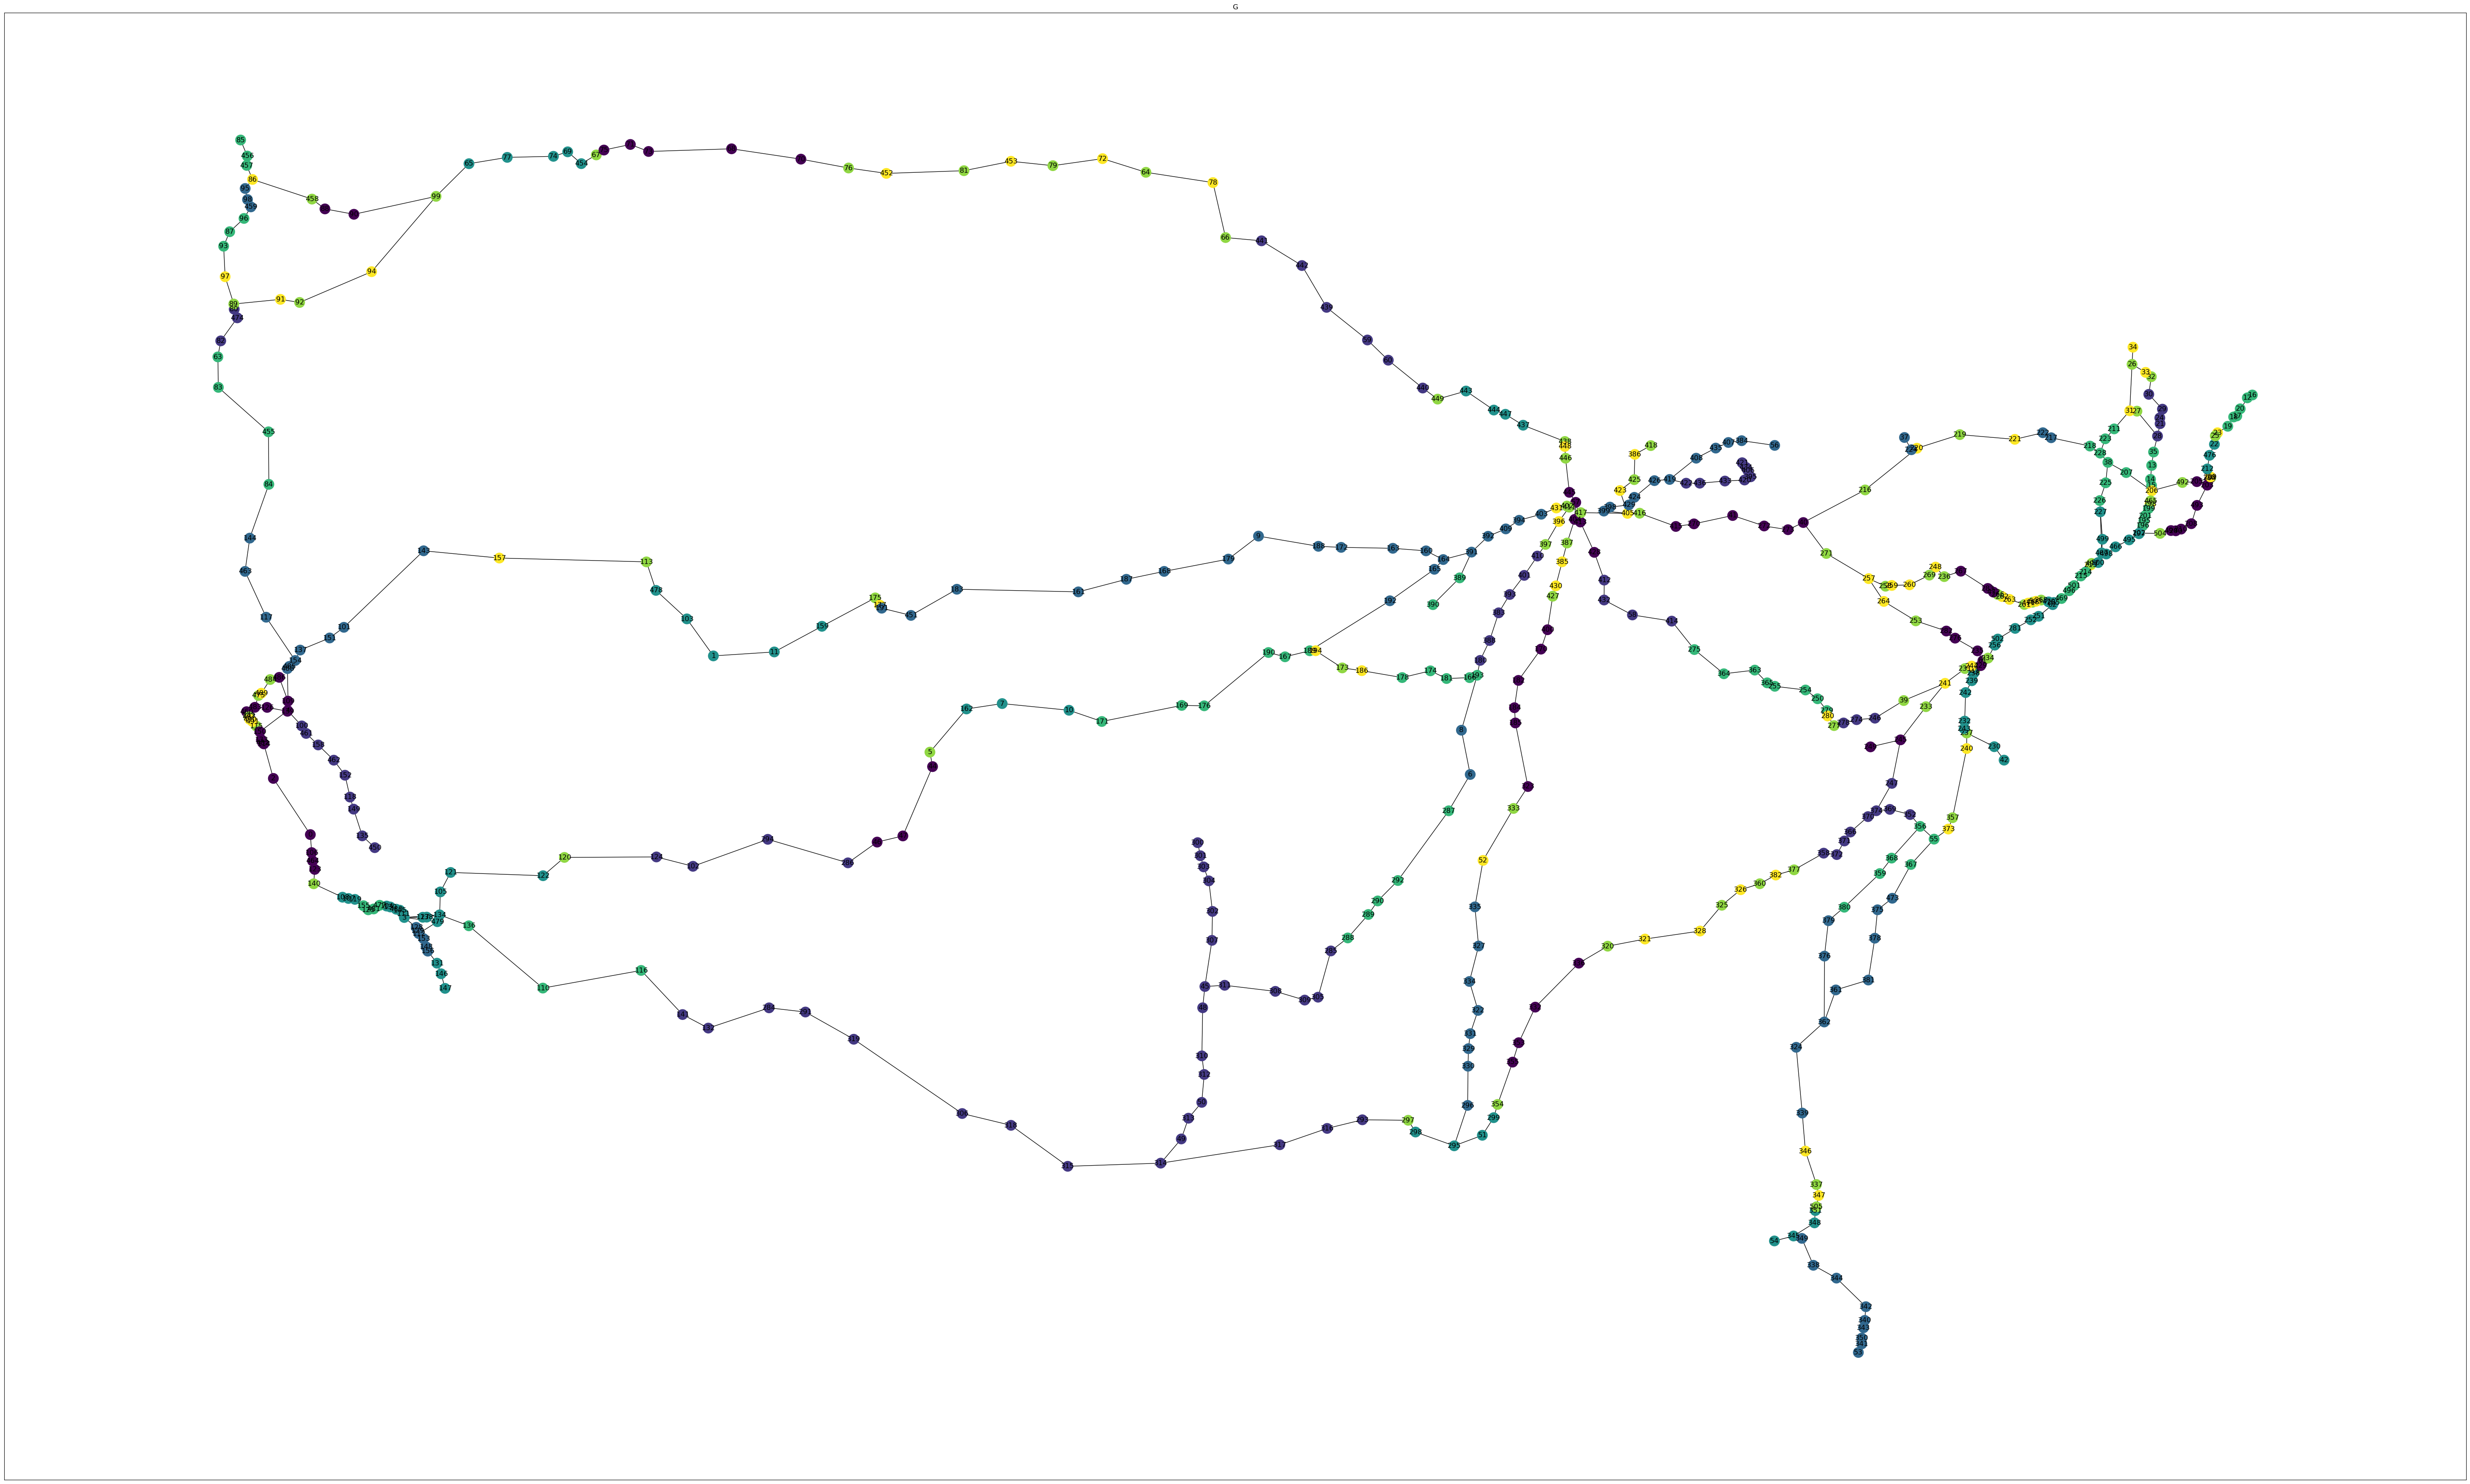

In [26]:


# Community assignment on the Karate Club graph
node_community_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
node_community_map = {}
for i in range(len(best_z)):
    node_community_map[i] = best_z[i]

# Assigning colors to nodes based on their community
colors = [best_z[node] for node in G.nodes()]
print("=== Initial ===")
print("z:", node_community_list)
# print(f"Log-Likelihood = {round(log_likelihood(G, best_z, 2),2 )}")
# Plotting the graph with nodes colored by community
x = dict(nx.get_node_attributes(G, 'x'))
y = dict(nx.get_node_attributes(G, 'y'))
pos = {}
KM = nx.get_edge_attributes(G, 'KM')
name = nx.get_node_attributes(G, 'name')
KM = {i: round(KM[i], 2) for i in KM}
for i in x:
    pos[i] = (x[i], y[i])
plt.figure(figsize=(75, 45))
nx.draw_networkx(G, pos=pos, node_color=colors, with_labels=True)
plt.title("G")
plt.savefig("plots/G.png")